# Entrenamiento de un Agente en el Entorno `Pendulum-v1` con TF-Agents

## ¿Qué es Gymnasium?

**Gymnasium** es una biblioteca de Python desarrollada por la comunidad de aprendizaje por refuerzo, diseñada para proporcionar una interfaz estandarizada para una amplia variedad de entornos simulados. Es el sucesor directo de `OpenAI Gym`, ahora mantenido por la organización Farama. 

Permite a los investigadores y desarrolladores:
- Probar algoritmos de aprendizaje por refuerzo (RL) de forma reproducible.
- Comparar distintos enfoques usando entornos bien definidos.
- Acceder a entornos clásicos, continuos, discretos y visuales, desde juegos simples hasta simulaciones complejas.

---

## ¿Qué es el entorno `Pendulum-v1`?

El entorno `Pendulum-v1` es un entorno clásico de control continuo. Su objetivo es controlar un péndulo invertido, es decir, aplicar torques para mantenerlo erguido en posición vertical, sin que caiga por gravedad.

Este entorno es un excelente caso de estudio para agentes que deben aprender políticas de control en **espacios de acción continuos**.

---

## Detalles del entorno

### Observación (`observation`)

El espacio de observación es un vector de **dimensión 3**, que representa el estado del péndulo:

- `cos(θ)` : el coseno del ángulo del péndulo respecto a la vertical.
- `sin(θ)` : el seno del ángulo.
- `θ_dot` : la velocidad angular del péndulo.

> La observación codifica el ángulo usando `cos(θ)` y `sin(θ)` para evitar discontinuidades en ±π.

---

### Acción (`action`)

El espacio de acción es **continuo**, con una única dimensión:

- Acción ∈ **[-2, 2]**, que representa el torque aplicado al péndulo.

> Este entorno **no permite acciones discretas**, lo cual tiene implicaciones en el tipo de algoritmos que se pueden usar para resolverlo (ver más abajo).

---

### Recompensa (`reward`)

La recompensa se calcula en cada paso como:

\[
r = - (\theta^2 + 0.1 \cdot \dot{\theta}^2 + 0.001 \cdot a^2)
\]

Donde:
- `θ` es el ángulo respecto a la posición vertical (idealmente cero),
- `θ_dot` es la velocidad angular,
- `a` es el torque aplicado.

Esto penaliza:
- El alejamiento del ángulo deseado (`θ ≠ 0`),
- La velocidad angular alta,
- El uso excesivo de energía (grandes torques).

> El agente debe aprender a estabilizar el péndulo en posición vertical con el mínimo esfuerzo posible.

---

## ¿Qué tipo de redes son apropiadas?

Dado que el entorno tiene un **espacio de acción continuo**, **no se pueden utilizar algoritmos basados en Q-Learning discreto**, como:

- `DQN` (Deep Q-Network)
- `Double DQN`
- `Dueling DQN`

Estos algoritmos están diseñados para problemas con un conjunto finito de acciones.

---

### Algoritmos apropiados (actor-crítico continuo)

Para `Pendulum-v1`, se deben usar **algoritmos actor-crítico** capaces de manejar acciones continuas:

- **DDPG** (Deep Deterministic Policy Gradient)
- **TD3** (Twin Delayed DDPG)
- **SAC** (Soft Actor-Critic)
- **PPO** (Proximal Policy Optimization, si se adapta)

Estos algoritmos utilizan dos redes principales:

1. **Actor (Política):** aprende a generar acciones óptimas.
2. **Crítico (Q-Value):** estima el valor de las acciones tomadas.

Este cuaderno implementará un agente basado en **DDPG**, entrenado con la biblioteca **TF-Agents**, y al final comparará su desempeño frente a una política aleatoria.

---

## ¿Qué analizaremos?

- Entrenamiento del agente con DDPG en `Pendulum-v1`.
- Gráfica del reward acumulado a lo largo del entrenamiento.
- Video del agente entrenado.
- Video de un agente que actúa aleatoriamente, como comparación.

---



In [1]:
# ✅ Instalar dependencias necesarias
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install gymnasium[classic-control]

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,564 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,399 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,909 kB]
Get:13 

xvfb: Sistema de framebuffer virtual que permite renderizar interfaces gráficas sin un monitor físico (útil en Colab o servidores remotos).

ffmpeg: Herramienta para codificar, grabar y convertir videos. Se usa para guardar los videos de simulación del agente.

freeglut3-dev: Implementación de OpenGL utilizada por los entornos visuales como Pendulum o CartPole.

imageio==2.4.0: Librería para crear y guardar imágenes/videos. La versión 2.4.0 es compatible con TF-Agents y pyvirtualdisplay.

pyvirtualdisplay: Permite emular una pantalla virtual, esencial para renderizar video en entornos sin GUI.

tf-agents[reverb]: Librería de TensorFlow para aprendizaje por refuerzo. La opción [reverb] activa un buffer de repetición eficiente para almacenar transiciones.

pyglet: Librería gráfica para Python, usada por muchos entornos de gym para mostrar animaciones.

gymnasium[classic-control]: Versión moderna de gym con soporte para entornos clásicos como Pendulum-v1, CartPole-v1, entre otros.

In [2]:
# === Imports principales ===
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tempfile
import os

from tf_agents.environments import tf_py_environment
from tf_agents.environments import gym_wrapper
from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver

import imageio
from pyvirtualdisplay import Display
import gym


2025-06-30 22:52:26.752285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-30 22:52:26.752379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-30 22:52:26.754367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/r

numpy, tensorflow, matplotlib: Librerías fundamentales para manejo de arrays, entrenamiento de redes neuronales y visualización.

tempfile, os: Herramientas del sistema para manejo de archivos temporales y operaciones sobre el sistema de archivos.

TF-Agents (tf_agents.*):

environments, gym_wrapper: Permiten envolver entornos de gym para ser compatibles con TF-Agents.

networks: Redes neuronales base para actores y críticos en DDPG.

ddpg_agent: Implementación del agente DDPG (Deep Deterministic Policy Gradient).

tf_uniform_replay_buffer: Buffer de repetición para almacenar experiencias de entrenamiento.

trajectory: Estructura que define las transiciones (estado, acción, recompensa, etc).

common: Funciones utilitarias para entrenamiento (ej. optimizadores, inicialización).

random_tf_policy: Política aleatoria útil para inicialización del buffer.

tf_metrics, dynamic_step_driver: Métricas de desempeño y colectores de pasos.

imageio: Permite crear y guardar videos cuadro por cuadro.

pyvirtualdisplay: Crea un display virtual (necesario para renderizar videos en Colab).

gym: Librería base de entornos de control clásico y otros benchmarks.

In [3]:
# === Activar display virtual para renderizar video
display = Display(visible=0, size=(1400, 900))
display.start()

# === Crear entornos usando gym clásico
env_name = "Pendulum-v1"
train_py_env = gym.make(env_name)
eval_py_env = gym.make(env_name)

# ✅ Envolverlos con GymWrapper
train_py_env = gym_wrapper.GymWrapper(train_py_env)
eval_py_env = gym_wrapper.GymWrapper(eval_py_env)

# ✅ Convertir a TFPyEnvironment
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# === Verificar specs
print("🔍 Observación:", train_env.observation_spec())
print("🎮 Acción:", train_env.action_spec())


🔍 Observación: BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32))
🎮 Acción: BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(-2., dtype=float32), maximum=array(2., dtype=float32))


Se crea un display virtual con pyvirtualdisplay. Esto es necesario en Kaggle y otros entornos sin GUI para poder renderizar los entornos de Gym y grabar videos (rgb_array).

Se selecciona el entorno clásico Pendulum-v1 de Gym.
Se crean dos instancias: una para entrenamiento (train_py_env) y otra para evaluación (eval_py_env).

GymWrapper convierte los entornos de gym en objetos compatibles con TF-Agents.

TFPyEnvironment convierte los entornos envueltos en estructuras completamente integradas con TensorFlow (permite ejecución en grafos, entrenamiento eficiente, etc.).

Se imprimen las especificaciones de observación y acción, que describen el espacio de entradas y salidas del entorno, útil para definir redes compatibles con el agente.

In [4]:
# === Extraer specs ===
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
time_step_spec = train_env.time_step_spec()

# === Redes personalizadas compatibles con TF-Agents ===
from tf_agents.networks import network

Se extraen las especificaciones del entorno para:

observation_spec: define la forma y tipo de datos de las observaciones (input).

action_spec: define el rango y tipo de las acciones posibles (output del actor).

time_step_spec: describe la estructura completa de un paso del entorno (incluye observación, recompensa, estado terminal, etc.).

Estas especificaciones son necesarias para construir redes compatibles con el agente.

Se importa la clase base network.Network, desde la cual se derivan las redes personalizadas de actor y crítico. Esta clase define una estructura común para que TF-Agents gestione redes en sus agentes.



En este proyecto usamos el algoritmo Deep Deterministic Policy Gradient (DDPG), que requiere dos redes principales:

🟢 Actor – genera la acción continua que el agente tomará dada una observación.

🔵 Crítico (Critic) – estima el valor Q de una pareja (observación, acción).



In [5]:
class CustomActor(network.Network):
    def __init__(self, observation_spec, action_spec, name='CustomActor'):
        super().__init__(input_tensor_spec=observation_spec, state_spec=(), name=name)
        self._action_limit = tf.constant(action_spec.maximum, dtype=tf.float32)
        self.model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=observation_spec.shape),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(action_spec.shape[0], activation='tanh'),
            tf.keras.layers.Lambda(lambda x: x * self._action_limit)
        ])

    def call(self, obs, step_type=None, network_state=(), training=False):
        return self.model(obs), network_state

class CustomCritic(network.Network):
    def __init__(self, observation_spec, action_spec, name='CustomCritic'):
        input_spec = (observation_spec, action_spec)
        super().__init__(input_tensor_spec=input_spec, state_spec=(), name=name)
        self.concat = tf.keras.layers.Concatenate()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(128, activation='relu')
        self.q_out = tf.keras.layers.Dense(1)

    def call(self, inputs, step_type=None, network_state=(), training=False):
        obs, act = inputs
        x = self.concat([obs, act])
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.q_out(x)
    
        # 🔧 Asegurar que q tiene forma [B, 1]
        q = tf.squeeze(q, axis=-1)  # ✅ Corregido: salida 1D
        return q, network_state

#Capa Actor

✔️ Objetivo
Aprender una función determinista μ(s) ≈ a, es decir, dada una observación del entorno s, predecir la acción continua a que maximice la recompensa a largo plazo.

✔️ Estructura
Capa	Descripción
InputLayer	Recibe vectores de observación (estado del entorno).
Dense(128, relu)	Primera capa oculta, aprende representaciones no lineales.
Dense(128, relu)	Segunda capa oculta, mayor capacidad de aprendizaje.
Dense(tanh)	Capa de salida: valores entre -1 y 1, que luego se escalan.
Lambda(x * max_a)	Escala la salida según el rango permitido por el entorno (action_spec).

✔️ Justificación
Se usan dos capas densas con ReLU por su buena capacidad de aproximación no lineal.

La salida se pasa por una función tanh, que limita el rango a [-1, 1].

Luego se escala al límite de acción permitido por el entorno, lo que garantiza que las acciones propuestas sean válidas.

#Capa Crítica

✔️ Objetivo
Aprender una función determinista μ(s) ≈ a, es decir, dada una observación del entorno s, predecir la acción continua a que maximice la recompensa a largo plazo.

✔️ Estructura
Capa	Descripción
InputLayer	Recibe vectores de observación (estado del entorno).
Dense(128, relu)	Primera capa oculta, aprende representaciones no lineales.
Dense(128, relu)	Segunda capa oculta, mayor capacidad de aprendizaje.
Dense(tanh)	Capa de salida: valores entre -1 y 1, que luego se escalan.
Lambda(x * max_a)	Escala la salida según el rango permitido por el entorno (action_spec).

✔️ Justificación
Se usan dos capas densas con ReLU por su buena capacidad de aproximación no lineal.

La salida se pasa por una función tanh, que limita el rango a [-1, 1].

Luego se escala al límite de acción permitido por el entorno, lo que garantiza que las acciones propuestas sean válidas.

Aunque TF-Agents ofrece redes predefinidas como ActorDistributionNetwork y QNetwork, optamos por definir nuestras propias redes para:

Tener control total sobre la arquitectura, activaciones y escalado.

Ajustar el output del actor al espacio de acciones continuas específicas del entorno (con tanh + escalado).

Adaptar fácilmente la forma de salida del crítico (q) para que sea compatible con el entrenamiento (tf.squeeze).

In [6]:
# === Crear instancias de las redes
actor_model = CustomActor(observation_spec, action_spec)
critic_model = CustomCritic(observation_spec, action_spec)

# ✅ Inicializar variables
dummy_obs = tf.random.uniform((1,) + observation_spec.shape)
dummy_act = tf.random.uniform((1,) + action_spec.shape)
actor_model(dummy_obs)
critic_model((dummy_obs, dummy_act))



(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.03111467], dtype=float32)>,
 ())

Después de definir las arquitecturas CustomActor y CustomCritic, creamos sus instancias concretas y forzamos una inicialización explícita de sus variables, que es un paso necesario antes de usarlas dentro del agente DDPG.

Aquí construimos:

actor_model: red neuronal que toma observaciones del entorno y devuelve una acción continua válida.

critic_model: red que toma un par (estado, acción) y devuelve el valor esperado (Q).

Estas redes personalizadas siguen las interfaces esperadas por TF-Agents, por lo que son totalmente compatibles con el agente DdpgAgent.


Se generan tensores aleatorios dummy_obs y dummy_act que respetan las dimensiones del entorno.

Estas muestras se pasan a las redes una vez para que TensorFlow cree internamente sus variables y estructuras.

Esto es especialmente útil cuando se usan redes personalizadas con capas como Dense, que requieren inicializar pesos antes de ser entrenadas.

⚠️ Si este paso se omite, podrías recibir errores durante la inicialización del agente DDPG, ya que internamente accede a los pesos del modelo.

In [7]:
# === Crear el agente
agent = ddpg_agent.DdpgAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    actor_network=actor_model,
    critic_network=critic_model,
    actor_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    critic_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    ou_stddev=0.2,
    ou_damping=0.15,
    target_update_tau=0.005,
    target_update_period=5,
    gamma=0.99,
    reward_scale_factor=1.0,
    train_step_counter=tf.Variable(0)
)

agent.initialize()
print("✅ Agente DDPG inicializado con éxito")


✅ Agente DDPG inicializado con éxito


El agente DDPG (Deep Deterministic Policy Gradient) es un algoritmo de aprendizaje por refuerzo off-policy diseñado para espacios de acción continuos. Se basa en el enfoque actor-crítico, donde:

El actor aprende una política determinista.

El crítico estima el valor Q de cada par (estado, acción).

⚙️ Parámetros claves
| Parámetro                 | Descripción                                                            |
| ------------------------- | ---------------------------------------------------------------------- |
| `time_step_spec`          | Especificación de entradas del entorno (`observation`, `reward`, etc.) |
| `action_spec`             | Especificación del espacio de acción continua del entorno              |
| `actor_network`           | Red neuronal personalizada que genera acciones a partir del estado     |
| `critic_network`          | Red neuronal que estima el valor Q para un par (estado, acción)        |
| `actor_optimizer`         | Optimizador del actor (más lento, `1e-4`)                              |
| `critic_optimizer`        | Optimizador del crítico (más rápido, `1e-3`)                           |
| `ou_stddev`, `ou_damping` | Parámetros del proceso Ornstein-Uhlenbeck para exploración ruidosa     |
| `target_update_tau`       | Proporción del soft update entre redes principales y redes objetivo    |
| `target_update_period`    | Frecuencia de actualización del objetivo                               |
| `gamma`                   | Factor de descuento para recompensas futuras                           |
| `reward_scale_factor`     | Escala de las recompensas para mejorar la estabilidad numérica         |
| `train_step_counter`      | Contador interno para rastrear los pasos de entrenamiento              |


In [8]:
# === Parámetros de entrenamiento ===
replay_buffer_capacity = 100_000
batch_size = 64
initial_collect_steps = 1000
collect_steps_per_iteration = 1
log_interval = 200
num_iterations = 25_000  # Ajustado para que se entrene ~1 hora

# === Política aleatoria para inicializar buffer ===
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

# === Replay Buffer ===
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity
)

Esta parte define los hiperparámetros del proceso de entrenamiento:

replay_buffer_capacity: tamaño máximo del buffer de experiencia. Se almacenan hasta 100,000 transiciones.

batch_size: número de muestras por batch durante el entrenamiento.

initial_collect_steps: pasos iniciales usando política aleatoria para llenar el buffer con datos diversos.

collect_steps_per_iteration: pasos que se recolectan del entorno por cada paso de entrenamiento.

log_interval: cada cuántos pasos se imprime el log de pérdida.

num_iterations: total de pasos de entrenamiento. Aquí se ha aumentado a 25,000 para una mejor convergencia.



In [9]:
# === Función para recolectar experiencia paso a paso ===
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

# === Rellenar el buffer con política aleatoria inicialmente ===
for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy, replay_buffer)
print("✅ Buffer inicializado con pasos aleatorios.")

✅ Buffer inicializado con pasos aleatorios.


Antes de entrenar al agente, se utiliza una política aleatoria para recolectar las primeras experiencias. Esto evita que el agente empiece desde un buffer vacío, lo cual podría causar errores o aprendizaje poco efectivo al principio.



In [10]:
# === Dataset desde buffer para entrenamiento ===
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

iterator = iter(dataset)

Convierte el ReplayBuffer en un dataset de TensorFlow, que se puede usar directamente para alimentar el proceso de entrenamiento del agente. Esto permite un entrenamiento eficiente, asincrónico y en forma de flujo continuo de datos (streaming).

In [11]:
# === Entrenamiento principal ===
returns = []
for i in range(num_iterations):
    # Colectar un paso con la política actual del agente
    collect_step(train_env, agent.collect_policy, replay_buffer)

    # Entrenar con un batch de datos
    experience, _ = next(iterator)

    #print(f"📐 experience.action shape: {experience.action.shape}")
    #print(f"📐 experience.observation shape: {experience.observation.shape}")

    # Entrenar conservando la forma [B, T, ...]
    try:
        train_loss = agent.train(experience).loss
    except Exception as e:
        print(f"❌ Error en agent.train: {e}")
        break

    # Log de progreso
    if i % log_interval == 0:
        print(f"🔁 Paso {i}: pérdida = {train_loss:.4f}")

    # Evaluación (opcional, no renderiza)
    if i % 1000 == 0:
        total_return = 0.0
        num_eval_episodes = 5
        for _ in range(num_eval_episodes):
            time_step = eval_env.reset()
            episode_return = 0.0
            while not time_step.is_last():
                action_step = agent.policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                episode_return += time_step.reward
            total_return += episode_return
        avg_return = total_return / num_eval_episodes
        returns.append(avg_return)
        print(f"✅ Recompensa promedio (eval) en paso {i}: {avg_return.numpy()[0]:.2f}")

🔁 Paso 0: pérdida = 5.7851
✅ Recompensa promedio (eval) en paso 0: -1363.55
🔁 Paso 200: pérdida = 0.3691
🔁 Paso 400: pérdida = 0.0840
🔁 Paso 600: pérdida = 0.0491
🔁 Paso 800: pérdida = 0.0629
🔁 Paso 1000: pérdida = 0.0658
✅ Recompensa promedio (eval) en paso 1000: -1672.09
🔁 Paso 1200: pérdida = 0.0697
🔁 Paso 1400: pérdida = 0.1831
🔁 Paso 1600: pérdida = 0.0761
🔁 Paso 1800: pérdida = 0.2765
🔁 Paso 2000: pérdida = 0.0392
✅ Recompensa promedio (eval) en paso 2000: -1498.87
🔁 Paso 2200: pérdida = 0.0606
🔁 Paso 2400: pérdida = 0.0539
🔁 Paso 2600: pérdida = 0.0907
🔁 Paso 2800: pérdida = 0.8803
🔁 Paso 3000: pérdida = 0.4053
✅ Recompensa promedio (eval) en paso 3000: -1463.19
🔁 Paso 3200: pérdida = 0.1187
🔁 Paso 3400: pérdida = 0.1097
🔁 Paso 3600: pérdida = 0.1332
🔁 Paso 3800: pérdida = 0.4516
🔁 Paso 4000: pérdida = 0.7774
✅ Recompensa promedio (eval) en paso 4000: -1476.53
🔁 Paso 4200: pérdida = 0.1804
🔁 Paso 4400: pérdida = 0.1171
🔁 Paso 4600: pérdida = 1.1498
🔁 Paso 4800: pérdida = 0.1795


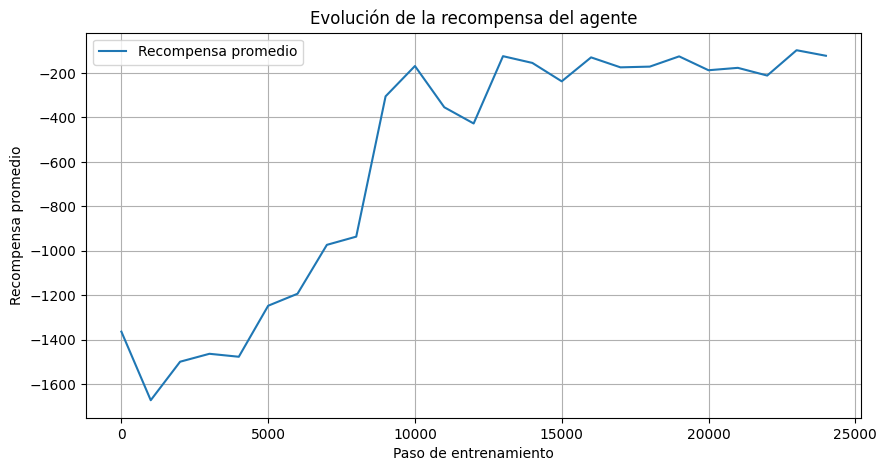

In [12]:
# === Gráfica de recompensa promedio ===
plt.figure(figsize=(10, 5))
steps = np.arange(0, len(returns)) * 1000
plt.plot(steps, [r.numpy()[0] for r in returns], label="Recompensa promedio")
plt.xlabel("Paso de entrenamiento")
plt.ylabel("Recompensa promedio")
plt.title("Evolución de la recompensa del agente")
plt.grid(True)
plt.legend()
plt.show()


Esta función genera un video de la política evaluada siguiendo estos pasos:

Inicializa el escritor de video con imageio.

Para cada episodio:

Reinicia el entorno real (eval_py_env) y el entorno TF (eval_env).

Renderiza el primer frame.

Mientras no termine el episodio:

Usa la política (policy) para decidir la acción.

Avanza un paso en el entorno TF.

Renderiza el siguiente frame.

Al finalizar, retorna el HTML del video incrustado.

🔁 Nota: Se ejecutan 3 episodios completos por defecto (num_episodes=3).

In [13]:
import base64
import IPython
import imageio

def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
    """Evalúa una política y guarda video en MP4."""
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            eval_py_env.reset()
            frame = eval_py_env.render(mode="rgb_array")
            video.append_data(frame)
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                frame = eval_py_env.render(mode="rgb_array")
                video.append_data(frame)
    return embed_mp4(filename)

# ✅ Crear y mostrar video del agente entrenado
create_policy_eval_video(agent.policy, "trained-agent")



[swscaler @ 0x5819cb9f4a40] Warning: data is not aligned! This can lead to a speed loss


In [14]:
# ✅ Crear y mostrar video del agente aleatorio
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x57507b30ba40] Warning: data is not aligned! This can lead to a speed loss
